# Bitácora de trabajo Rizosfera

## 2020-03-05 Clasificación taxonómica Rizosfera

En el servidor de Bios se creó una carpeta llamada "classifier-rhizosphere", dentro de ella se encuentran los archivos "rep-seqs.qza" correspondientes a los reads de la rizosfera y el clasificador "classifier.qza".

Luego se ejecutó el clasificador:

```sh
screen
time qiime feature-classifier classify-sklearn \
  --i-classifier classifier.qza \
  --i-reads rep-seqs.qza \
  --o-classification taxonomy-rhizosphere.qza
```

## Inferencia filogenética

Se realizó un alineamiento de las secuencias mediante MAFFT en el servidor de BIOS:

```bash
cd rhizosphere
mkdir phylogenetic-tree
cd phylogenetic-tree

qiime alignment mafft \
  --i-sequences ../rep-seqs-rh.qza \
  --o-alignment aligned-rep-seqs-rh.qza```
  
Luego se hizo el masking para eliminar posiciones no informativas:

```bash
qiime alignment mask \
  --i-alignment aligned-rep-seqs-rh.qza \
  --o-masked-alignment masked-aligned-rep-seqs-rh.qza```
  
Luego se realizó el árbol mediante FastTree:

```bash
qiime phylogeny fasttree \
  --i-alignment masked-aligned-rep-seqs-rh.qza \
  --o-tree fasttree-tree-rh.qza```
  
Por último se hizo el enraizado del árbol:

```bash
qiime phylogeny midpoint-root \
  --i-tree fasttree-tree-rh.qza \
  --o-rooted-tree fasttree-tree-rooted-rh.qza```
  
## Barplot de la clasificación



```bash
cd Documentos/genomeseq/rhizosphere/classifier/

qiime taxa barplot \
  --i-table table-rh.qza \
  --i-taxonomy taxonomy-rhizosphere.qza \
  --m-metadata-file ../metadata_rhizosphere.tsv \
  --o-visualization taxa-bar-plots-rh.qzv```

## 2020-03-18 Reunión por Meet, pasos a seguir

Crear gráficas que permitan ir escribiendo el artículo. La gráfica debe explicarse a sí misma.

### Figuras publicación

Se creó un archivo de LibreOffice Impress con las figuras tentativas y su respectiva leyenda.

## 2020-03-25

Estefany me mandó la tabla de ASVs en formato .tsv, así que en el servidor de BIOS la convertí a .biom mediante el siguiente comando:

```bash
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere$ biom convert -i rhizosphere_asv.tsv -o table-rh.biom --to-hdf5```

Luego convertí el .biom en un .qza:
```bash
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere$ qiime tools import \
    --input-path table-rh.biom \
    --type 'FeatureTable[Frequency]' \
    --output-path feature-table-rh.qza```
    

## Análisis de composición (ANCOM)

También estoy analizando la composición para saber qué ASVs están en diferentes abundancias en las diferentes muestras, se corrieron los siguientes comandos:

```bash
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere/ancom-composition-analysis$ qiime composition add-pseudocount \
    --i-table feature-table-rh.qza \
    --o-composition-table comp-table-rh.qza
    
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere/ancom-composition-analysis$ time qiime composition ancom \
    --i-table comp-table-rh.qza \
    --m-metadata-file ../metadata_rhizosphere.tsv \
    --m-metadata-column Plant_status \
    --o-visualization ancom-plant-status-rh.qzv
```

El último comando se demora mucho (incluso en el servidor de BIOS) y no ha funcionado.

**2020-03-27:** El comando funcionó después de arreglar el archivo de metadatos intercambiando de lugar las dos primeras columnas.

El resultado fue el siguiente:

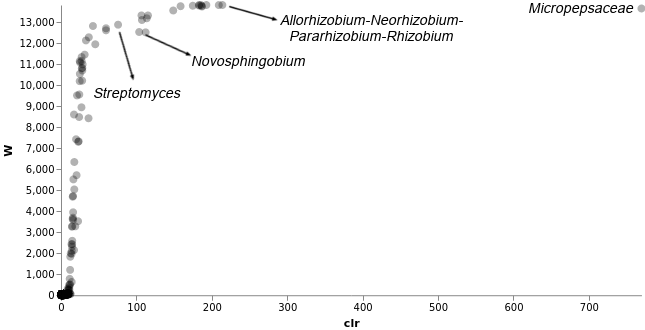

## ANCOM solo con suelo cultivado

Como esperamos que entre el suelo no cultivado y el cultivado cambie más las entidades taxonómicas, es mejor crear un set de datos solamente con el suelo cultivado y comparar Modern y Ancestral:

```bash
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere/ancom-composition-analysis$ qiime feature-table filter-samples \
    --i-table feature-table-rh.qza \
    --m-metadata-file metadata_rhizosphere.tsv \
    --p-where "[Plant_status]!='NA'" \
    --o-filtered-table only-cultured-soil-ancom/cultured-soil-table--rh.qza

```

Luego se volvió a realizar el análisis ANCOM:

```bash
(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere/ancom-composition-analysis/only-cultured-soil-ancom$ qiime composition add-pseudocount \
    --i-table cultured-soil-table--rh.qza \
    --o-composition-table comp-table-cultured-rh.qza

(qiime2-2019.10) jeperezj@r1masterl01:~/jcar/rhizosphere/ancom-composition-analysis/only-cultured-soil-ancom$ time qiime composition ancom \
    --i-table comp-table-cultured-rh.qza \
    --m-metadata-file ../metadata_rhizosphere.tsv \
    --m-metadata-column Plant_status \
    --o-visualization ancom-plant-status-cultured-rh.qzv
```
Este es el resultado:

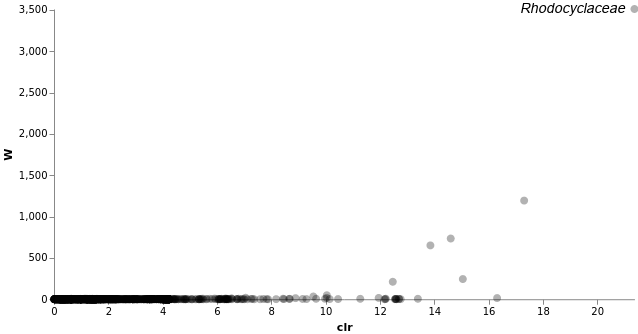

## Visualización de la clasificación taxonómica:

```bash
(qiime2-2019.10) nesper@gojira-E402MA:~/Documentos/genomeseq/rhizosphere/classifier$ qiime metadata tabulate \
    --m-input-file taxonomy-rhizosphere.qza \
    --o-visualization taxonomy-rhizosphere.qzv
```

# 2020-04-01 Reunión Meet

Por hacer:
- Ayudarle a Estefa con análisis de abundancia diferencial en R con el paquete MetagenomeSeq.
- Seguir con el ANCOM.
- Leer paper ANCOM.
- Seguir con el árbol filogenético en iTOL.